# 쇼어 알고리즘

쇼어 알고리즘은 다항시간으로 인수분해를 하는 것으로 유명합니다. 가장 잘 알려진 고전 알고리즘은 두 소수의 곱을 인수분해하는데 다항식 보다 큰 시간이 필요하기 때문에 널리 사용되는 암호화 프로토콜인 RSA는 인수분해하기 어려운 충분히 큰 정수를 사용합니다.

이 장에서는 사실상 *주기 찾기* 문제를 해결하는 쇼어 알고리즘의 양자 부분에 대해서 집중할 것입니다. 소인수분해 문제는 다항시간안에 해결할 수 있는 주기 찾기 문제로 바뀔 수 있기 때문에, 효율적인 주기 찾기 알고리즘은 정수를 소인수분해 하는데에도 효율적으로 사용될 수 있습니다. 현재로서는 $a^x\bmod N$의 주기를 효율적으로 계산할 수 있다면, 곧 효율적으로 소인수분해 할 수 있음을 보이는 것으로 충분합니다. 주기 찾기가 그 자체로도 가치가 있는 문제이기 때문에, 우리는 우선 이 문제를 해결하고, 그리고 나서 이것이 어떻게 소인수분해에 사용될 수 있는지 5절에서 논의하겠습니다.

In [1]:
# pylint: disable=invalid-name
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


## 1. 문제: 주기 찾기

다음 주기 함수를 살펴보도록 합시다:

```
$$ f(x) = a^x \bmod{N}$$
```

<details>     <summary>알림: 모듈로 및 모듈식 산술 (확장하려면 여기를 클릭)</summary> </details>

('mod'로 축약되는) 모듈로 연산은 단순히 하나의 수를 다른 수로 나누었을 때의 나머지를 찾는 것을 의미합니다. 예를 들면:

```
$$ 17 \bmod 5 = 2 $$
```

$17 \div 5 = 3$ 이고 나머지가 $2$ 이기 때문입니다. (즉, $17 = (3\times 5) + 2$) 파이썬에서 모듈로 연산은 <code>%</code> 기호로 표시합니다.

이러한 동작은 특정 값(모듈러스)에 도달하면 숫자가 '반올림'되는 <a href="https://en.wikipedia.org/wiki/Modular_arithmetic">모듈러 산술</a>에 사용됩니다. 모듈러 산술을 이용하여 다음과 같이 쓸 수 있습니다.

```
$$ 17 = 2 \pmod 5$$
```

여기서 $\pmod 5$는 방정식의 왼쪽에만 적용되는 위의 방정식과는 다르게 괄호 안에 있으므로 전체 방정식에 적용됩니다.




또한 $a$ 및 $N$은 양의 정수이고 $a$는 $N$보다 작으며 공약수가 없습니다. 주기 또는 차수($r$)는 다음과 같이 0이 아닌 가장 작은 정수 입니다.

```
$$a^r \bmod N = 1 $$
```

아래 그래프에서 이 함수의 예를 확인할 수 있습니다. 점 사이의 선으로 주기성을 확인할 수 있으며 x 마커 사이의 중간 값은 표시하지 않습니다.

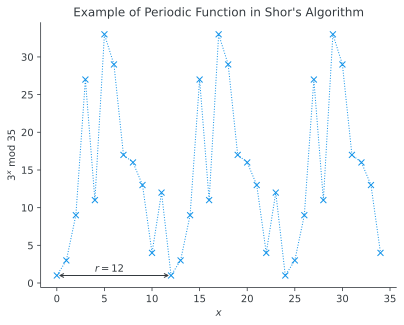

In [2]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

## 2. 해법

쇼어의 해법은 유니타리 연산자에 대해 [양자 위상 추정](./quantum-phase-estimation.html) 을 사용하는 것이었습니다.

```
$$ U|y\rangle \equiv |ay \bmod N \rangle $$
```

이것이 얼마나 유용한지 알기 위해 U 의 고유상태가 어떻게 생겼는지 알아보겠습니다. $|1\rangle$ 상태에서 시작하면 U를 연속적으로 적용할 때마다 레지스터 상태에 $a \pmod N$를 곱하고   $r$을 적용한 후에 다시 $|1\rangle$ 상태가 된다는 것을 알 수 있습니다. 예를 들어 $a = 3$ 과 $N = 35$ 인 경우는 다음과 같습니다.

$$\begin{aligned}
U|1\rangle &amp;= |3\rangle &amp; \\
U^2|1\rangle &amp;= |9\rangle \\
U^3|1\rangle &amp;= |27\rangle \\
&amp; \vdots \\
U^{(r-1)}|1\rangle &amp;= |12\rangle \\
U^r|1\rangle &amp;= |1\rangle
\end{aligned}$$

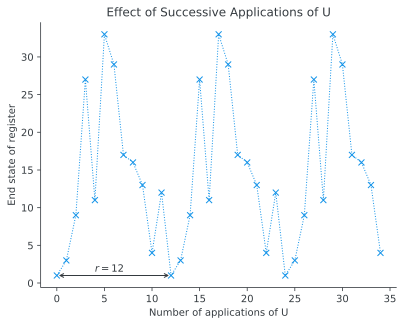

In [3]:
ax.set(xlabel='Number of applications of U',
       ylabel='End state of register',
       title="Effect of Successive Applications of U")
fig

따라서 이 주기 ($|u_0\rangle$)의 중첩 상태는 $U$의 고유상태가 됩니다.

```
$$|u_0\rangle = \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{|a^k \bmod N\rangle} $$
```

<details>     <summary>클릭하여 펼치기: $a = 3$ 및 $N=35$인 예제</summary> </details>

$$\begin{aligned}
|u_0\rangle &amp;= \tfrac{1}{\sqrt{12}}(|1\rangle + |3\rangle + |9\rangle \dots + |4\rangle + |12\rangle) \\[10pt]
U|u_0\rangle &amp;= \tfrac{1}{\sqrt{12}}(U|1\rangle + U|3\rangle + U|9\rangle \dots + U|4\rangle + U|12\rangle) \\[10pt]
 &amp;= \tfrac{1}{\sqrt{12}}(|3\rangle + |9\rangle + |27\rangle \dots + |12\rangle + |1\rangle) \\[10pt]
 &amp;= |u_0\rangle
\end{aligned}$$




이 고유상태는 고유값이 1이며, 이는 그다지 흥미롭지 않습니다. 보다 흥미로운 고유 상태는 이러한 계산 기저 상태 각각에 대해 위상이 다른 고유 상태일 수 있습니다. 구체적으로 $k^\text{th}$ 상태의 위상이 $k$에 비례하는 경우를 살펴봅니다.

$$\begin{aligned}
|u_1\rangle &amp;= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_1\rangle &amp;= e^{\tfrac{2\pi i}{r}}|u_1\rangle
\end{aligned}
$$

클릭하여 펼치기: $a = 3$ 과 $N=35$ 인 경우의 예

$$\begin{aligned}
|u_1\rangle &amp;= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i}{12}}|4\rangle + e^{-\tfrac{22\pi i}{12}}|12\rangle) \\[10pt]
U|u_1\rangle &amp;= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i}{12}}|9\rangle + e^{-\tfrac{4\pi i}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i}{12}}|12\rangle + e^{-\tfrac{22\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &amp;= e^{\tfrac{2\pi i}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{\tfrac{-2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle + e^{-\tfrac{6\pi i}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i}{12}}|12\rangle + e^{-\tfrac{24\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &amp;= e^{\tfrac{2\pi i}{12}}|u_1\rangle
\end{aligned}$$

($r = 12$가 위상의 분모에 나타나는 것을 볼 수 있습니다.)




고윳값에 $r$이 있다는 것이 특히 흥미롭습니다. 사실 $r$ 계산 기저 상태간의 위상차가 같다는 것을 확실히 하기위해 $r$이 포함되어야 합니다. 이 고윳값이 이러한 행동을 갖는 유일한 고유 상태는 아닙니다. 좀 더 일반화 하기 위해 정수 $s$를 위상차가 고발 수 있습니다. 이는 고윳값에 나타납니다.

$$\begin{aligned}
|u_s\rangle &amp;= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i s k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_s\rangle &amp;= e^{\tfrac{2\pi i s}{r}}|u_s\rangle
\end{aligned}
$$

<details>     <summary>클릭하여 펼치기: $a = 3$ 및 $N=35인 예$</summary> </details>

$$\begin{aligned}
|u_s\rangle &amp;= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|4\rangle + e^{-\tfrac{22\pi i s}{12}}|12\rangle) \\[10pt]
U|u_s\rangle &amp;= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i s}{12}}|9\rangle + e^{-\tfrac{4\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|12\rangle + e^{-\tfrac{22\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &amp;= e^{\tfrac{2\pi i s}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle + e^{-\tfrac{6\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i s}{12}}|12\rangle + e^{-\tfrac{24\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &amp;= e^{\tfrac{2\pi i s}{12}}|u_s\rangle
\end{aligned}$$




이제 $0 \leq s \leq r-1$ 범위에 있는 $s$의 각 정수 값에 대해 고유상태를 얻었습니다. 매우 편리하게도 이러한 모든 고유상태를 더하면 $|1\rangle$을 제외한 모든 계산 기저 상태는 다른 위상에 의해 제거됩니다.

```
$$ \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} |u_s\rangle = |1\rangle$$
```

<details>     <summary>클릭하여 펼치기: $a = 7$ 및 $N=15$인 예</summary> </details>

$a = 7$ 와 $N=15$ 인 더 작은 예제를 살펴보겠습니다. $r=4$ 인 경우는 다음과 같습니다.

$$\begin{aligned}
\tfrac{1}{2}(\quad|u_0\rangle &amp;= \tfrac{1}{2}(|1\rangle \hphantom{e^{-\tfrac{2\pi i}{12}}}+ |7\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |4\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |13\rangle)\dots \\[10pt]
+ |u_1\rangle &amp;= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{2\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}4\pi i}{4}}|4\rangle + e^{-\tfrac{\hphantom{1}6\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_2\rangle &amp;= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{4\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}8\pi i}{4}}|4\rangle + e^{-\tfrac{12\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_3\rangle &amp;= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{6\pi i}{4}}|7\rangle + e^{-\tfrac{12\pi i}{4}}|4\rangle + e^{-\tfrac{18\pi i}{4}}|13\rangle)\quad) = |1\rangle \\[10pt]
\end{aligned}$$




계산 기저 상태 $|1\rangle$은 이러한 고유 상태의 중첩이므로 $|1\rangle$ 상태를 사용하여 $U$에 대해 QPE를 수행하면 위상을 측정할 수 있습니다.

```
$$\phi = \frac{s}{r}$$
```

여기서 $s$는 $0$ 과 $r-1$사이에 있는 무작위 정수 입니다. 끝으로 $\phi$에 대해 [연분수](https://en.wikipedia.org/wiki/Continued_fraction) 알고리즘을 사용하여 $r$을 찾습니다. 회로도는 다음과 같습니다. (이 회로도는 Qiskit의 큐비트 순서 규칙을 따릅니다.):

<img src="images/shor_circuit_1.svg">

다음으로 Qiskit 시뮬레이터를 이용하여 쇼어의 알고리즘을 설명할 것입니다. 이 데모에서는 설명 없이 $U$에 대한 회로를 사용하지만 4절 에서는 $U^{2^j}$를 효과적으로 구성할 수 있는 방법에 대해 설명합니다.

## 3. Qiskit 구현

이 예제에서 $a=7$ 와 $N=15$에 대해 주기 찾기 문제를 풀 것 입니다. $U$ 회로는 다음과 같습니다.

```
$$U|y\rangle = |ay\bmod 15\rangle $$
```

$U^x$에 대한 별다른 설명없이 회로를 $x$번 반복합니다. 다음 절 에서는 이 회로를 효율적으로 생성할 수 있는 일반적인 방법을 논의합니다. 함수 `c_amod15`는`power`번 반복하여 `a`에 대한 제어 U 게이트를 반환합니다.

In [4]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

8 카운팅 큐비트를 사용할 것입니다.

In [5]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 7

또한 QFT 회로를 import 합니다. ([양자 푸리에 변환 장](./quantum-fourier-transform.html#generalqft)에서 QFT에 대해 더 많을 것을 알 수 있습니다.)

In [6]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

다음 블록을 구성하여 쇼어 알고리즘 회로를 쉽게 구성할 수 있습니다.

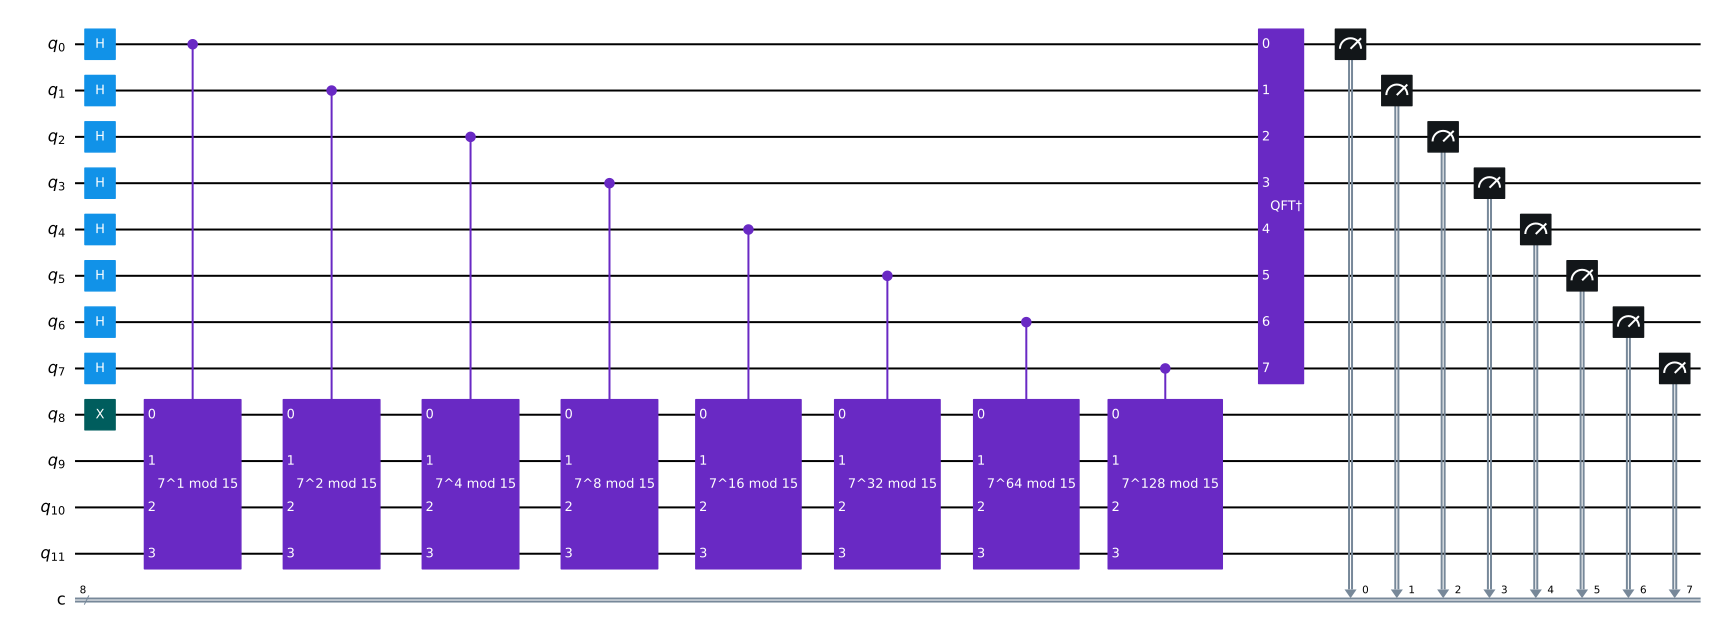

In [7]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1)  # -1 means 'do not fold'

어떤 결과를 측정하는지 살펴봅시다.

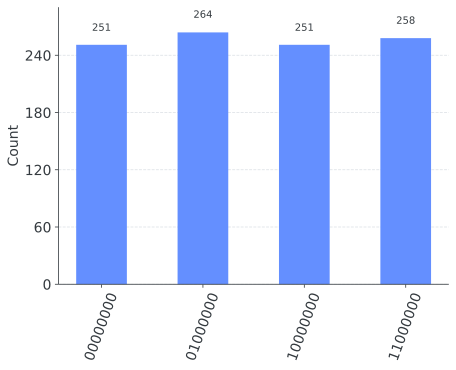

In [8]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

8개의 큐비트가 있으므로 결과는 다음과 같이 측정한 위상이 됩니다.

In [9]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  11000000(bin) = 192(dec)  192/256 = 0.75
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  01000000(bin) =  64(dec)   64/256 = 0.25


이제 연분수 알고리즘을 사용해서 $s$ 와 $r$를 찾을 수 있습니다. 파이썬은 이를 위한 내장 함수가 있습니다. 다음과 같이 `fractions` 모듈을 사용해서 실수를 `분수` 객체로 바꿀 수 있습니다.

In [10]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

이 함수는 정확한 분수를 반환하기 때문에 (이 경우 `0.6660000...`) 위와 같이 복잡한 결과가 나올 수 있습니다. `.limit_denominator()` 함수를 사용해서 특정값 아래의 분모를 사용하여 실수와 가장 유사한 분수를 구할 수 있습니다.

In [11]:
# 분모 < 15를 사용하여 
# 0.666 에 가장 가까운 분수를 구한다.
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

좀 더 보기 좋습니다. 차수 (r)은 반드시 N 보다는 작아야 하므로 최대 분모를  `15`로 설정합니다.

In [12]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.75      3/4            4
2   0.50      1/2            2
3   0.25      1/4            4


측정된 고유값 중 두 개가 올바른 결과과 $r=4$임을 알 수 있으며 Shor 알고리즘이 실패할 가능성 또한 존재함을 알 수 있습니다. 이처럼 좋지 않은 결과는 $s = 0$ 이거나 $s$ 와 $r$가 서로소가 아니기 때문입니다. 이를 위한 가장 쉬운 해결책은 $r$에 대해 만족하는 결과를 얻을 때까지 실험을 반복하는 것입니다.

### 막간 퀴즈

- $a = 2, 8, 11$, $13$ 값에 대해 위 회로를 변경하십시오. 어떤 결과를 얻었고 그 이유는 무엇입니까?

## 4. Modular 지수화

$U$를 반복하여 $U^{2^j}$ 게이트를 만드는 방법은 $j$에 대해 지수적으로 증가하고 다항시간 알고리즘이 아님을 알게 되셨을 것입니다. 다음과 같은 연산자를 생성하는 방법이 필요합니다.

```
$$ U^{2^j}|y\rangle = |a^{2^j}y \bmod N \rangle $$
```

이는 $j$에 대해 다항식으로 증가합니다. 다행히도 다음을 효율적으로 계산할 수 있습니다.

```
$$ a^{2^j} \bmod N$$
```

고전 컴퓨터는 *반복 제곱*이라는 알고리즘을 사용하여 지수를 계산할 수 있습니다. 위 문제의 경우 $2^j$ 형태의 지수만 다루기 때문에 반복 제곱 알고리즘은 매우 간단해집니다.

In [13]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for _ in range(j):
        a = np.mod(a**2, N)
    return a

In [14]:
a2jmodN(7, 2049, 53)

47

파이썬에서 효율적인 알고리즘이 가능하다면 양자 컴퓨터에서도 같은 알고리즘을 사용할 수 있습니다. 하지만 불행히도 $j$에 대해 다항식으로 증가함에도 불구하고 모듈러 지수 회로는 간단하지 않으며 쇼어 알고리즘의 병목 현상이 됩니다. 초보자에게 적합한 구현은 참고문헌 [1]에서 찾을 수 있습니다.

## 5. 주기 찾기를 활용한 인수분해

모든 인수분해 문제가 어려운 것은 아닙니다. 짝수를 발견하면 그 인수 중 하나가 2 라는 것을 알 수 있습니다. 사실 인수분해가 어려운 수를 선택하는 [특정 기준](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.186-4.pdf#%5B%7B%22num%22%3A127%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C70%2C223%2C0%5D)이 있지만 기본 아이디어는 두 개의 큰 소수를 곱하는 것입니다.

일반적인 인수분해 알고리즘은 최악의 경우에 대해 쇼어의 주기 찾기를 사용하기 전에 먼저 숫자가 짝수인지? $N = a^b$ 형식의 수 인지? 등을 통해 정수를 인수분해할 수 있는 지름길이 있는지 확인합니다. 이 글에서는 알고리즘의 양자 부분을 목표로 하기 때문에 N이 두 소수의 곱인 경우로 바로 넘어갈 것입니다.

### 예제: 15의 인수분해

15를 인수분해 하여 소수의 큐비트에 대한 예를 들어보겠습니다. 15는 이미 알고 있듯 그다지 크지 않은 소수 3과 5의 곱입니다.

In [15]:
N = 15

첫 번째 단계는 $1$ 과 $N-1$ 사이의 난수 $a$를 선택하는 것입니다.

In [16]:
np.random.seed(1) # 재현할 수 있는 결과를 위해 사용합니다. 
a = randint(2, 15)
print(a)

7


다음으로 이 숫자가 $N$의 인수가 아닌지 빠르게 확인합니다.

In [17]:
from math import gcd # 최대 공약수
gcd(a, N)

1

다음으로  we do Shor's order finding algorithm for `a = 7` 와 `N = 15`에 대해 쇼어의 주기 찾기 알고리즘을 수행합니다. 측정하려는 위상이 $s/r$ 임을 기억하십시오.

```
$$ a^r \bmod N = 1 $$
```

$s$는 0 과 $r-1$ 사이의 임의의 정수입니다.

In [18]:
def qpe_amod15(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase

이 단계에서 $r$ 값을 쉽게 추측할 수 있습니다.

In [19]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15)

Register Reading: 00000000
Corresponding Phase: 0.000000


Fraction(0, 1)

In [20]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

1


이제 $r$을 구했습니다. 이를 사용해서 $N$의 인수를 찾을 수 있습니다.

```
$$a^r \bmod N = 1 $$
```

그러면

```
$$(a^r - 1) \bmod N = 0 $$
```

이는 $a^r-1$ 은 반드시 $N$으로 나누어 함을 의미합니다. $r$이 짝수이면 다음과 같습니다.

```
$$a^r -1 = (a^{r/2}-1)(a^{r/2}+1)$$
```

($r$이 짝수가 아니면 더이상 진행할 수 없으며 다른 $a$값으로 시도해야 합니다). 그러면 $N$과 $a^{r/2}-1$ 또는 $a^{r/2}+1$의 최대 공약수가 $N$의 적절한 인수일 가능성이 높습니다 [2].

In [21]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[15, 1]


아래 셀은 최소 15의 인수 1개를 찾을 때까지 알고리즘을 반복합니다. 셀이 어떻게 동작하는지 보려면 셀을 몇 번 다시 실행해야 합니다.

In [22]:
a = 7
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print("*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 01000000
Corresponding Phase: 0.250000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


In [23]:
# The cell below repeats the algorithm until at least one factor of 15
# is found
assert (3 in guesses) or (5 in guesses)

## 6. 참고문헌

1. Stephane Beauregard, *Circuit for Shor's algorithm using 2n+3 qubits,* [arXiv:quant-ph/0205095](https://arxiv.org/abs/quant-ph/0205095)

2. M. Nielsen and I. Chuang, *Quantum Computation and Quantum Information,* Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000). (Page 633)

In [24]:
# pylint: disable=unused-import
import qiskit.tools.jupyter
%qiskit_version_table